In [3]:
import features
import numpy as np
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dataloader
import pitchspace
import visualization

filepath = "/home/max/ET-TI/Masterarbeit/chord-recognition/results/correlation_median_drums.hdf5"
classifier = pitchspace.Classifier()


/home/max/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [4]:

dset = "rwc_pop"
track_id = "RM-P080" 

# RM-P002 , rwc_pop
# -> shows that the threshold for the hcdf is a crucial parameter
# -> F-min7 with a missing root note 

# RM-P006 Funky life, sevenths alphabet funktioniert hier überhaupt nicht
# RM-P027 interesting for No chord modeling
# RM-P010 Interessant weil liegender Ton mit hoher Energie, HCDF threshold
# RM-P035 -> chord change can be corrected with HCDF
# 0301 Hard days night, 0607 Michelle, 0702 Eleanor Rigby

dataset = dataloader.Dataloader(dset,"/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata","drums")

audiopath, annotationpath = dataset[track_id] 
sig = utils.loadAudiofile(audiopath)
dcp = features.deepChroma(audiopath)
gt = utils.loadChordAnnotations(annotationpath)
chroma = features.crpChroma(sig,nCRP=33)
t_audio = utils.timeVector(len(sig),hop_length=1,sr=22050)
t_chroma = utils.timeVector(chroma.shape[1],hop_length=2048)

## load recognition result for track
track_data,chromadata,ground_truth,est_majmin,est_sevenths = visualization.load_trackdata(filepath,track_id,dset)
print(track_data)

track(track_id='RM-P080', name='Sagashimono', dataset='rwc_pop', majmin_wscr=0.68, majmin_seg=0.85, majmin_f=0.76, sevenths_wscr=0.55, sevenths_seg=0.91, sevenths_f=0.69)


## How to find chord boundaries?

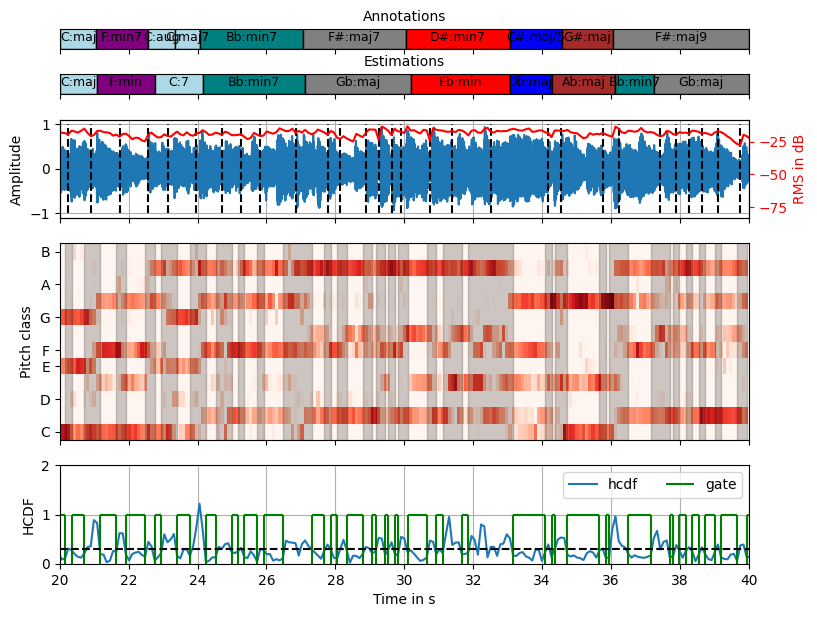

In [5]:
import itertools

rms = features.computeRMS(sig)
hcdf = pitchspace.computeHCDF(chroma,prefilter_length=3,use_cpss=False)

## thresholding
threshold = 0.3
min_distance = 1
gate = np.zeros_like(hcdf)
gate[hcdf < threshold] = 1
chroma_indices = []
start_index = 0

for i, value in enumerate(gate):
    if value == 1:
        if start_index is None:
            start_index = i
    elif start_index is not None:
        # check if the interval is long enough
        if i - start_index > min_distance: 
            chroma_indices.append((start_index, i-1))
        start_index = None
# check if last index is still ongoing
if start_index is not None:
    chroma_indices.append((start_index, len(gate) - 1))

time_interval = (20,40)
fig,(ax0,ax00,ax1,ax2,ax3) = plt.subplots(5,1,height_ratios=(1,1,5,10,5),figsize=(8,6))
utils.plotChordAnnotations(ax0,gt[0],gt[1],time_interval)
ax0.set_title('Annotations',fontsize=10)
utils.plotChordAnnotations(ax00,est_sevenths[0],est_sevenths[1],time_interval)
ax00.set_title('Estimations',fontsize=10)
ax1.plot(t_audio,sig)
ax1.set_ylabel("Amplitude")
ax1.grid("on")
ax12 = ax1.twinx()
ax12.plot(t_chroma,rms,'-',color="r")
ax12.set_ylabel("RMS in dB", color='red')
ax12.tick_params('y', colors='red')
utils.plotChromagram(ax2,t_chroma,chroma,time_interval)
ax3.plot(t_chroma,hcdf)
for x,y in itertools.pairwise(chroma_indices):
    x_i0,x_i1 = x 
    y_i0,y_i1 = y
    chord_change_index = (x_i1 + y_i0) // 2     # chord change in between stable regions
    ax1.vlines(t_chroma[chord_change_index],-1,1,'k',linestyle="--")
    rect = patches.Rectangle((t_chroma[x_i1],-0.5),t_chroma[y_i0] - t_chroma[x_i1],12,facecolor="k",alpha=0.1,edgecolor="k")
    ax2.add_patch(rect)
    ax2.add_artist(rect)
for indices in chroma_indices:
    ax3.hlines(1,t_chroma[indices[0]],t_chroma[indices[1]],'green')
    ax3.vlines([t_chroma[indices[0]],t_chroma[indices[1]]],[0,0],[1,1],'green')
ax3.hlines(threshold,time_interval[0],time_interval[1],'k',linestyle="--")

ax3.set_ylabel("HCDF")
ax3.set_ylim(0,2)
ax3.set_xlim(time_interval)
ax3.grid("on")
xticks = np.linspace(time_interval[0],time_interval[1],num=11)
ax3.set_xticks(xticks)
ax3.set_xlabel("Time in s")
ax3.legend(["hcdf","gate"],loc=1,ncols=2)
for ax in (ax0,ax00):
    ax.set_yticks([])
for ax in (ax0,ax00,ax1,ax2):
    ax.set_xlim(time_interval)
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    ax.set_xlabel("")

fig.tight_layout(pad=0.1)
# fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/refined_harmonic_change.png")


### Refine estimation with CPSS 

check if the time gap between two unstable regions is larger than 400ms. </br>
if True then insert a "No chord" label into the  estimation, </br>
if False adjust the time intervals such that the chord transition is in between the two stable regions

In [126]:
# No chord until first stable region
est_cpss_intervals = [[0,t_chroma[chroma_indices[0][0]]]]
est_cpss_labels = ["N"]

for x in chroma_indices:
    chroma_avg = np.average(chroma[:,x[0]:x[1]],axis=1)
    label, likelyhood = classifier.classify(chroma_avg)
    
    t_start = t_chroma[x[0]]
    t_stop = t_chroma[x[1]]
    # check time difference to last stable region
    dt = t_start - est_cpss_intervals[-1][1]
    if dt < 1:
        # adjust intervals
        t_start -= dt/2
        est_cpss_intervals[-1][1] += dt/2
    else:
        # add no chord for the unstable region in between the last and current region
        est_cpss_labels.append("N")
        est_cpss_intervals.append([est_cpss_intervals[-1][1],t_start])
    # add current region
    est_cpss_intervals.append([t_start, t_stop])
    est_cpss_labels.append(label)
    
est_cpss_intervals = np.array(est_cpss_intervals)


For every chord estimation find all overlapping intervals

----Sevenths----
cpss: (0.57, 0.69)
hmm: (0.55, 0.91)
----Majmin----
cpss: (0.64, 0.69)
hmm: (0.85, 0.91)


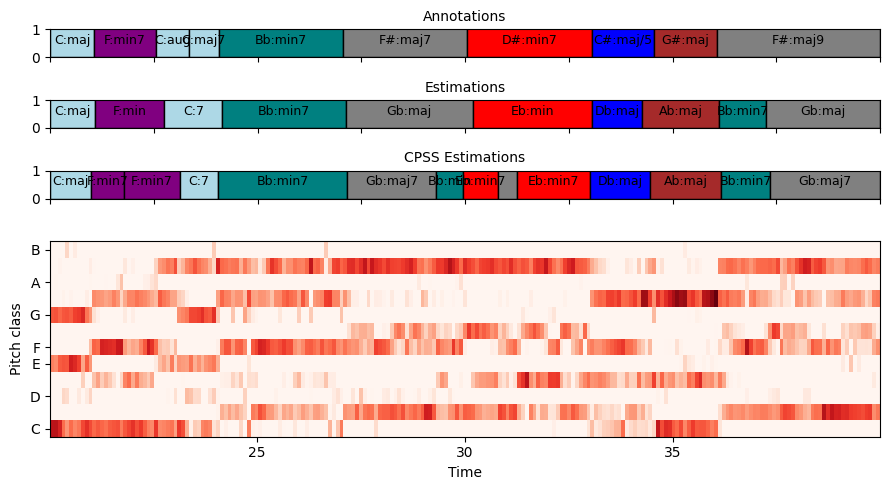

In [127]:
fig,(ax0,ax1,ax2,ax3) = plt.subplots(4,1,height_ratios=(1,1,1,7),figsize=(9,5))
utils.plotChordAnnotations(ax0,gt[0],gt[1],time_interval)
ax0.set_title('Annotations',fontsize=10)
utils.plotChordAnnotations(ax1,est_sevenths[0],est_sevenths[1],time_interval)
ax1.set_title('Estimations',fontsize=10)
utils.plotChordAnnotations(ax2,est_cpss_intervals,est_cpss_labels,time_interval)
ax2.set_title('CPSS Estimations',fontsize=10)
for ax in [ax0,ax1,ax2]:
    ax.set_xticklabels([])

utils.plotChromagram(ax3,t_chroma,chroma,time_interval)
fig.tight_layout()

print("----Sevenths----")
x = utils.evaluateTranscription(est_cpss_intervals,est_cpss_labels,ground_truth[0],ground_truth[1],"sevenths")
print(f"cpss: {x}")
x = utils.evaluateTranscription(est_sevenths[0],est_sevenths[1],ground_truth[0],ground_truth[1],"sevenths")
print(f"hmm: {x}")

x = utils.evaluateTranscription(est_cpss_intervals,est_cpss_labels,ground_truth[0],ground_truth[1],"majmin")
print("----Majmin----")
print(f"cpss: {x}")
x = utils.evaluateTranscription(est_sevenths[0],est_sevenths[1],ground_truth[0],ground_truth[1],"majmin")
print(f"hmm: {x}")

In [6]:
# load chromadata
import h5py
import mir_eval

filepath = "/home/max/ET-TI/Masterarbeit/chord-recognition/models/chromadata_root_invariant_median.hdf5" 

with  h5py.File(filepath,"r") as file:
    data = {}
    for group in file:
        try:
            root,qual,scale_deg,bass = group.split("-")
            label = mir_eval.chord.join(root,qual,eval(scale_deg),bass)
        except ValueError:
            label = "N"
        data[label] = file[group].get(group)
    major = np.copy(data["C:maj"])
    minor = np.copy(data["C:min"])
    maj7 = np.copy(data["C:maj7"])
    min7 = np.copy(data["C:min7"])
    dom7 = np.copy(data["C:7"])
    
selected_data = []
indices = [0,12,24,36,48] # indices for C:maj, C:min, C:maj7, C:7, C:min7
for chromadata,index in zip([major, minor, maj7, dom7, min7],[0,12,24,36,48]):
    corr,labels = features.computeCorrelation(chromadata,inner_product=False,template_type="sevenths")
    # choose a subset of chromadata where the correlation with the original template is the highest
    highest_correlation = np.argmax(corr,axis=0)
    selected_data.append((index,chromadata[:,highest_correlation == index]))

/home/max/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [37]:

def shannonEntropy(chroma):
    """calculates the Shannon entropy of a chromagram for every timestep. The chromavector is treated as a random variable."""
    if chroma.shape[0] != 12:
        raise ValueError("invalid Chromagram shape!")
    return -np.sum(np.multiply(chroma,np.log2(chroma+np.finfo(float).eps)), axis=0)/np.log2(12)

def energyRelation(chroma):
    x_sorted = np.sort(chroma,axis=0)
    x_4 = np.sum(x_sorted[8:,:],axis=0)
    x_3 = np.sum(x_sorted[9:,:],axis=0) 
    x_2 = np.sum(x_sorted[10:,:],axis=0)
    return x_2, x_3, x_4


/tmp/ipykernel_32742/1019210356.py:5: RuntimeWarning: invalid value encountered in log2
  return -np.sum(np.multiply(chroma,np.log2(chroma+np.finfo(float).eps)), axis=0)/np.log2(12)


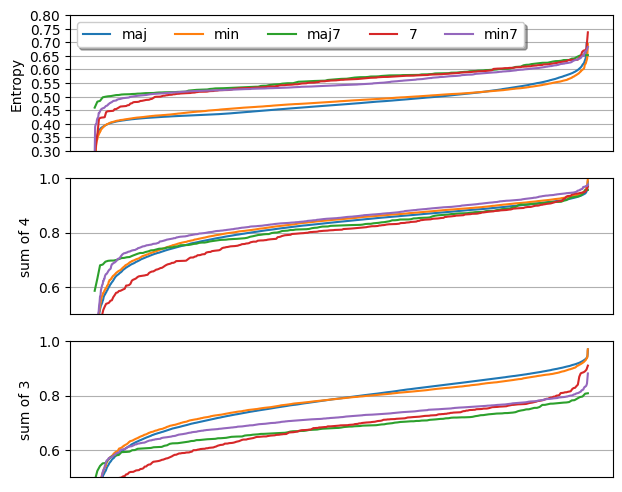

In [39]:
# Plot chromadata that has been selected for training

for i in range(5):
    fig,ax = plt.subplots(figsize=(4,3))
    time = utils.timeVector(selected_data[i][1].shape[1]) 
    utils.plotChromagram(ax,time, selected_data[i][1])
    ax.set_xticks([])
    ax.set_xlabel("")
    # fig.savefig(f"/home/max/ET-TI/Masterarbeit/latex/figures/chromadata_{i}.png")
    plt.close()

# analyze complexity features
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig,(ax,ax1,ax2) =  plt.subplots(3,figsize=(7,6))
for i in range(5):
    time = np.linspace(0,50,selected_data[i][1].shape[1])
    chroma = selected_data[i][1] / np.linalg.norm(selected_data[i][1],1)
    entropy = np.sort(shannonEntropy(chroma))
    ax.plot(time,entropy,color=colors[i])
    ax.set_ylabel("Entropy")

    x_2,x_3,x_4 = energyRelation(chroma)
    ax1.plot(time,np.sort(x_4),color=colors[i],linestyle="-")
    ax1.set_ylabel("sum of 4")
    ax2.plot(time,np.sort(x_3),color=colors[i],linestyle="-")
    ax2.set_ylabel("sum of 3")
ax.set_ylim(0.3,0.8)
for axes in [ax,ax1,ax2]:
    axes.grid(True)
    axes.set_xticks([])

ax1.set_ylim(0.5,1)
ax2.set_ylim(0.5,1)
ax.set_yticks(np.arange(0.3,0.85,0.05))
ax.legend(["maj","min","maj7","7","min7"],ncols=5,fancybox=True,shadow=True)

# fig.savefig(f"/home/max/ET-TI/Masterarbeit/latex/figures/entropy.png")


### Visualization of Data in the key of C

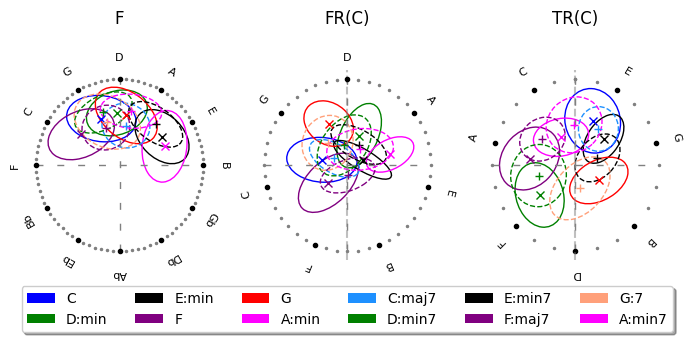

In [ ]:
# Duplicate vectors to gather data in key of C
# C,Dm,Em,F,G,Am,Bdim
I = ("C",selected_data[0][1],"blue","-")
II = ("D:min",np.roll(selected_data[1][1],2,axis=0),"green","-")
III = ("E:min",np.roll(selected_data[1][1],4,axis=0),"black","-")
IV = ("F",np.roll(selected_data[0][1],5,axis=0),"purple","-")
V = ("G",np.roll(selected_data[0][1],7,axis=0),"red","-")
VI = ("A:min",np.roll(selected_data[0][1],9,axis=0),"magenta","-")
# VII = ("Bdim",np.roll(selected_dim,,axis=0),"red")   

# add maj7, min7 and 7 chords to the 
# Cmaj7, Dmin7, Emin7,Fmaj7,G7,Amin7
I_7 = ("C:maj7",selected_data[2][1],"dodgerblue","--")
II_7 = ("D:min7",np.roll(selected_data[4][1],2,axis=0),"green","--")
III_7 = ("E:min7",np.roll(selected_data[4][1],4,axis=0),"black","--")
IV_7 = ("F:maj7",np.roll(selected_data[2][1],5,axis=0),"purple","--")
V_7 = ("G:7",np.roll(selected_data[3][1],7,axis=0),"lightsalmon","--")
VI_7 = ("A:min7",np.roll(selected_data[4][1],9,axis=0),"magenta","--")

chromadata = [I,II,III,IV,V,VI,I_7,II_7,III_7,IV_7,V_7,VI_7]
# chromadata = [I,I_7,V,V_7]
fig,(ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(7,3.2))
ax0.text(0,1.7,f"F",ha='center',va='center',fontsize=12)
ax1.text(0,1.7,f"FR(C)",ha='center',va='center',fontsize=12)
ax2.text(0,1.7,f"TR(C)",ha='center',va='center',fontsize=12)
utils.plotCircleF(ax0)
utils.plotCircleFR(ax1, 0)
utils.plotCircleTR(ax2, 0)
fig.subplots_adjust(left=0.1, top=0.9)
fig.tight_layout(w_pad=1,h_pad=1)  

legend_elements = []

for data in chromadata:
    label,chroma,color,linestyle = data
    F,FR,TR,DR = pitchspace.computeCPSSfeatures(chroma)
    mu_F = np.mean(F[:2],axis=1)
    mu_FR = np.mean(FR[:2,:],axis=1)
    mu_TR = np.mean(TR[:2,:],axis=1)
    cov_F = np.cov(F[0,:],F[1,:])
    cov_FR = np.cov(FR[0,:],FR[1,:])
    cov_TR = np.cov(TR[0,:],TR[1,:])
    
    utils.confidence_ellipse(F[0,:],F[1,:],ax0,n_std=3,edgecolor=color,linestyle=linestyle)
    utils.confidence_ellipse(FR[0,:],FR[1,:],ax1,n_std=3,edgecolor=color,linestyle=linestyle)
    utils.confidence_ellipse(TR[0,:],TR[1,:],ax2,n_std=3,edgecolor=color,linestyle=linestyle)
    if linestyle == "--":
        marker = "+"
    else:
        marker = "x"
    ax0.plot(mu_F[0],mu_F[1],marker,color=color)
    ax1.plot(mu_FR[0],mu_FR[1],marker,color=color)
    ax2.plot(mu_TR[0],mu_TR[1],marker,color=color)

    legend_elements.append(patches.Patch(facecolor=color,label=label,linestyle=linestyle))

ax1.legend(handles=legend_elements,loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=6);


In [ ]:
#### plot Covariance matrices

